# Machine Learning Model: Which Beta Bank customers are looking to switch banks?

Beta bank is facing challenges when it comes to customer retention. Rather than investing in attracting new customers, the bank thinks the best way forward is to try and retain existing customers.

In this project we will attempt to use the principles of supervised machine learning to identify customers who plan to leave Beta Bank in the near future.

To train our model, we have customer data which also includes data from customers who have already left(exited).

For this project it is important that the model selected has the highest F1 score, with a minimum F1 score of 0.59.

The F1 score is the harmonic mean of recall and precision. Recall indicates how well the model is able to recognize the class while precision is a measure of how often it misidentifies another class as the class of interest. F1 score is a way to control precision and recall simultaneously and as the two values increase, F1 approaches 1.

The project will proceed in three stages.

1. We will process the data and examine the distribution of the classes of interest (exited versus retained customers). Other patterns of interest in the data will also be examined.

2. We will split the data into training, validation and test sets in a 3:1:1 ratio. We will then train logical regression, decision tree and random forest models on the training set with and without taking class imbalance into account. At least two different methods to address class imbalance will be used to find the best approach.

3. We will perform a few sanity checks on the model and then run a final test to see how it does on the test set.

In [33]:
#importing required libraries
import pandas as pd
import numpy as np
from scipy import stats as st
from scipy.stats import randint
import seaborn as sns
from matplotlib import pyplot as plt
import plotly as py
import plotly.express as px
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.utils import shuffle

In [2]:
#loading the data and examining it
data = pd.read_csv('/datasets/Churn.csv')
data.info()
display(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


There are 10000 rows of data spread across 13 columns. The data types assigned are mostly correct. Tenure could be changed to int type since they are the number of years. It would also make sense to make all the column headers in lower case for ease of later processing. There is not a lot of missing data, the only column that has missing data is Tenure where the missing data comprises less than 10% of the entire set. We could use regression to predict the values and fill it in or just fill it with the median based on the distribution of the data. It could also be that this represents users who have been at the bank for less than a year, which would mean the value is actually zero. 

In [3]:
data_na = data[data['Tenure'].isna()]
display(data_na.sample(10))
data_z = data[data['Tenure'] == 0]
display(data_z.sample(10))

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
1582,1583,15631072,Huie,690,France,Male,38,NaN,94456.00,2,0,1,55034.02,0
935,936,15675316,Avdeeva,619,France,Female,38,NaN,0.00,2,0,1,116467.35,0
542,543,15776223,Davide,597,France,Female,42,NaN,64740.12,1,1,1,106841.12,0
7274,7275,15680901,Potter,652,France,Female,34,NaN,97435.85,2,1,1,104331.76,0
6484,6485,15668629,Saunders,719,Spain,Male,44,NaN,0.00,2,1,0,196582.19,0
6732,6733,15718588,Meng,548,France,Female,37,NaN,0.00,2,0,0,98029.58,0
9417,9418,15656829,Hughes,577,Spain,Female,33,NaN,0.00,2,1,0,57975.80,0
3574,3575,15683375,Compton,541,France,Female,32,NaN,0.00,1,1,1,114951.42,0
5449,5450,15592028,Roberts,549,France,Female,46,NaN,0.00,1,1,1,109057.56,0
7846,7847,15755416,Hart,557,France,Female,27,NaN,87739.08,1,1,1,123096.56,0


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
5432,5433,15616471,Milne,599,Spain,Male,51,0.0,0.00,1,1,1,175235.99,0
4532,4533,15739194,Manfrin,548,Spain,Male,38,0.0,178056.54,2,1,0,38434.73,0
2452,2453,15578825,Golubev,734,France,Female,29,0.0,139994.66,1,1,0,17744.72,0
8174,8175,15623525,Copeland,564,Spain,Male,31,0.0,125175.58,1,1,1,72757.33,0
2637,2638,15677435,Kazantseva,647,France,Female,29,0.0,98263.46,2,1,0,164717.95,0
6194,6195,15794273,Hand,604,France,Female,56,0.0,62732.65,1,0,1,124954.56,0
3614,3615,15747649,Summerville,558,Germany,Female,36,0.0,126606.63,2,1,1,172363.52,0
956,957,15631681,Jibunoh,807,Spain,Female,43,0.0,0.00,2,0,1,85523.24,0
7277,7278,15571284,Elmore,756,Germany,Male,32,0.0,109528.16,2,1,1,56176.31,0
7589,7590,15620832,Dean,723,France,Female,35,0.0,0.00,2,0,1,61290.99,0


It is not customers who have been at the bank for less than a year who have mising values for tenure. Since we have customers with tenure values that are listed as zero separately. We will convert the type after imputing and filling in values.

In [4]:
# transform all column names and object type columns to lowercase before proceeding with further processing
data.columns = data.columns.str.lower()
data['surname'] = data['surname'].str.lower()
data['geography'] = data['geography'].str.lower()
data['gender'] = data['gender'].str.lower()
data.info()
display(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   rownumber        10000 non-null  int64  
 1   customerid       10000 non-null  int64  
 2   surname          10000 non-null  object 
 3   creditscore      10000 non-null  int64  
 4   geography        10000 non-null  object 
 5   gender           10000 non-null  object 
 6   age              10000 non-null  int64  
 7   tenure           9091 non-null   float64
 8   balance          10000 non-null  float64
 9   numofproducts    10000 non-null  int64  
 10  hascrcard        10000 non-null  int64  
 11  isactivemember   10000 non-null  int64  
 12  estimatedsalary  10000 non-null  float64
 13  exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


,rownumber,customerid,surname,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
0,1,15634602,hargrave,619,france,female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,hill,608,spain,female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,onio,502,france,female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,boni,699,france,female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,mitchell,850,spain,female,43,2.0,125510.82,1,1,1,79084.10,0


In [5]:
print(data.duplicated().sum())
print(data['customerid'].duplicated().sum())

0
0


There do not appear to be any duplicates rows or duplicated customer ids. We can proceed with filling in the null values with imputation. We will use the iterative imputer as there may be underlying feature dependencies that determine the tenure feature value.

In [6]:
iterative_imputer = IterativeImputer(estimator=ExtraTreesRegressor(n_estimators=100,
                                                                   min_samples_leaf=1,
                                                                   min_samples_split=4,
                                                                   random_state=12345),
                                     max_iter=20,
                                     tol=1e-2,
                                     initial_strategy='median',
                                     verbose=True,
                                     random_state=12345)
imputed_data = iterative_imputer.fit_transform(data[['creditscore','age','isactivemember', 'estimatedsalary','tenure','numofproducts','hascrcard','balance']])
data.loc[:,['creditscore','age','isactivemember', 'estimatedsalary','tenure','numofproducts','hascrcard','balance']] = imputed_data
data.info()
data.sample(20)

[IterativeImputer] Completing matrix with shape (10000, 8)
[IterativeImputer] Change: 3.313333333333336, scaled tolerance: 2508.9809 
[IterativeImputer] Early stopping criterion reached.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   rownumber        10000 non-null  int64  
 1   customerid       10000 non-null  int64  
 2   surname          10000 non-null  object 
 3   creditscore      10000 non-null  float64
 4   geography        10000 non-null  object 
 5   gender           10000 non-null  object 
 6   age              10000 non-null  float64
 7   tenure           10000 non-null  float64
 8   balance          10000 non-null  float64
 9   numofproducts    10000 non-null  float64
 10  hascrcard        10000 non-null  float64
 11  isactivemember   10000 non-null  float64
 12  estimatedsalary  10000 non-null  float64
 13  exited    

,rownumber,customerid,surname,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
4935,4936,15804862,toscani,505.0,germany,male,43.0,6.000000,127146.68,1.0,0.0,0.0,137565.87,0
2399,2400,15672516,wall,541.0,germany,male,51.0,7.000000,90373.28,2.0,1.0,0.0,179861.79,0
6552,6553,15636407,beatham,793.0,germany,female,34.0,4.925000,127758.09,1.0,1.0,0.0,143357.03,0
288,289,15727556,o'donnell,744.0,spain,female,26.0,5.000000,166297.89,1.0,1.0,1.0,181694.44,0
2784,2785,15642202,whitfield,821.0,germany,female,37.0,5.000000,106453.53,2.0,0.0,1.0,127413.00,0
4125,4126,15633378,davidson,692.0,spain,female,49.0,9.000000,0.00,2.0,1.0,0.0,178342.63,0
2546,2547,15755178,ramos,660.0,france,male,50.0,4.581667,0.00,3.0,1.0,1.0,191849.15,1
4171,4172,15748481,howey,564.0,france,female,27.0,6.000000,0.00,1.0,0.0,0.0,7819.76,0
6845,6846,15734085,crocker,465.0,germany,male,24.0,5.000000,117154.90,1.0,1.0,1.0,127744.02,0
57,58,15647091,endrizzi,725.0,germany,male,19.0,0.000000,75888.20,1.0,0.0,0.0,45613.75,0


In [7]:
#convert tenure to type int
data['tenure'] = data['tenure'].astype('int64')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   rownumber        10000 non-null  int64  
 1   customerid       10000 non-null  int64  
 2   surname          10000 non-null  object 
 3   creditscore      10000 non-null  float64
 4   geography        10000 non-null  object 
 5   gender           10000 non-null  object 
 6   age              10000 non-null  float64
 7   tenure           10000 non-null  int64  
 8   balance          10000 non-null  float64
 9   numofproducts    10000 non-null  float64
 10  hascrcard        10000 non-null  float64
 11  isactivemember   10000 non-null  float64
 12  estimatedsalary  10000 non-null  float64
 13  exited           10000 non-null  int64  
dtypes: float64(7), int64(4), object(3)
memory usage: 1.1+ MB


## Initial examination of the data

Let us look at how the data is distributed and note down any characteristics that may influence machine learning outcomes.

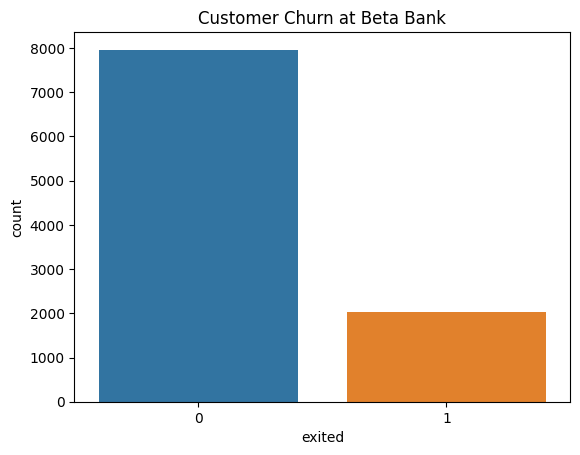

In [8]:
#looking at number of users per plan
leavers = sns.countplot(x='exited', data=data)
leavers.set_title('Customer Churn at Beta Bank')
plt.show()

There is clearly a class imbalance here with far for customers who are still bank customers represented in the data compared to those who left. The customers who left are a fourth of those who stayed.

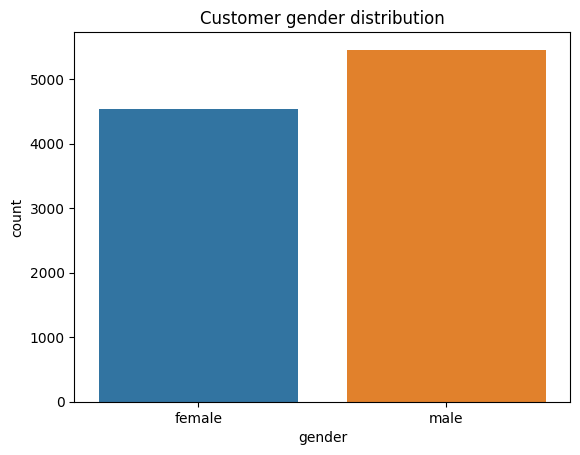

In [9]:
#looking at number of users per plan
leavers = sns.countplot(x='gender', data=data)
leavers.set_title('Customer gender distribution')
plt.show()

The gender distribution is fairly balanced, fewer women than men, but not by much.

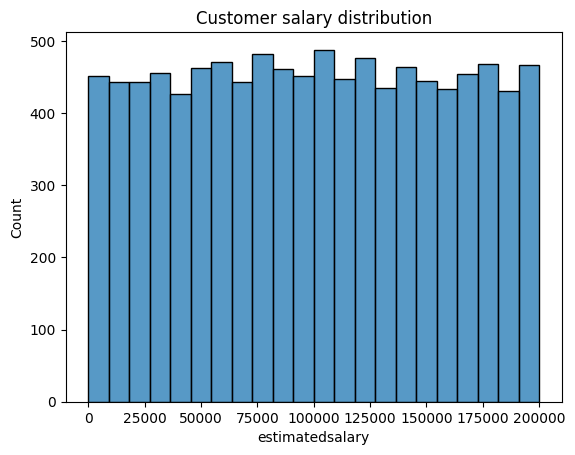

In [10]:
#histograms of salary
sns.histplot(data=data['estimatedsalary'])
plt.title('Customer salary distribution')
plt.show()

The salary ranges are fairly evenly distributed across salary ranges. It would be good to see if there is a difference by geography or gender.

In [11]:
data_geo = data.groupby('geography')[['creditscore','age','isactivemember', 'estimatedsalary','tenure','numofproducts','hascrcard','balance','exited']].mean()
data_gender = data.groupby('gender')[['creditscore','age','isactivemember', 'estimatedsalary','tenure','numofproducts','hascrcard','balance','exited']].mean()
data_geo.reset_index()
data_gender.reset_index()

,gender,creditscore,age,isactivemember,estimatedsalary,tenure,numofproducts,hascrcard,balance,exited
0,female,650.831389,39.238389,0.502751,100601.541382,4.919877,1.544134,0.702619,75659.369139,0.250715
1,male,650.276892,38.658237,0.525380,99664.576931,4.986256,1.518600,0.707898,77173.974506,0.164559


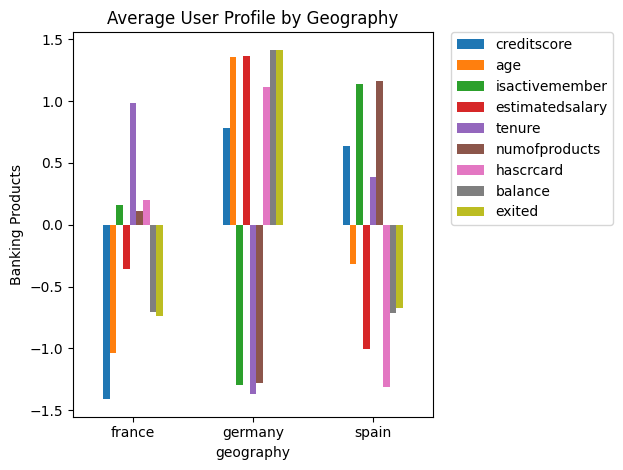

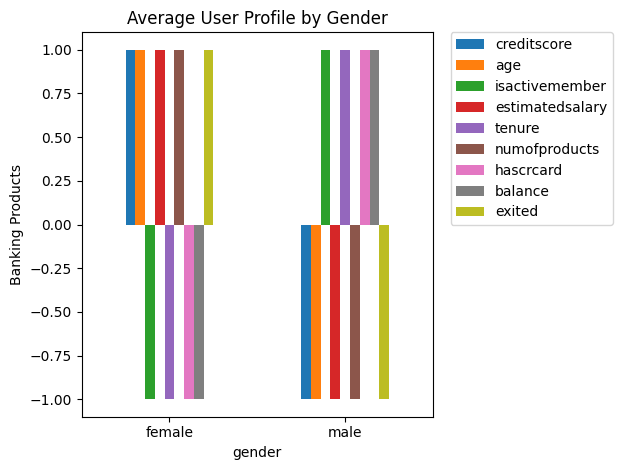

In [12]:
scaler = StandardScaler()
scaler.fit(data_geo)
data_geo_scaled = scaler.transform(data_geo)
df_geo = pd.DataFrame(data_geo_scaled, index=data_geo.index, columns=data_geo.columns)
df_geo.plot(kind='bar')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title('Average User Profile by Geography')
plt.ylabel('Banking Products')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()
scaler.fit(data_gender)
data_gender_scaled = scaler.transform(data_gender)
df_gender = pd.DataFrame(data_gender_scaled, index=data_gender.index, columns=data_gender.columns)
df_gender.plot(kind='bar')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title('Average User Profile by Gender')
plt.ylabel('Banking Products')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

We can see that there are different user profiles geographically and also by gender. 
The data has been scaled so what we see is a distribution about the mean which allows for easier comparison.

**Geographic Distribution**

German users are the most conservative using the least number of financial products and seem to leave the bank more frequenctly which is also borne out by their shorter tenures at the bank and their low activity. This is a concerning since these are high income customers with higher credit scores, who have a tendency to apply for credit cards, usually park larger amounts at the bank and are older, which would imply having a larger and more stable ivestmentment portfolio. Why does Beta bank struggle to retain customers in Germany?
    France appears to home to a more loyal customer base but these appear to be young professionals, relatively early in their careers who are trying to build their credit scores. If Beta Bank has low barriers to access compared to the competitors it could explain the attractiveness. The question is do they migrate to other service providers once they have better credit? What can be done to encourage them to stay as they transtion to a more stable stage in their careers?
    Spanish customers are more active users and open to trying more financial products and on average have better credit scores than their French counterparts. They are also on average older than their French counterparts but not by much.
    
**Gender Distribution**

This distribution is quite interesting. The Male and Female profiles are near opposites.
Women are more likely to leave Beta and which is borne out by the short tenures and the low activity and the lower likelihood of having a credit card with Beta and maintaining low balances. However, they are hughly desirable with their high credit scores, salaries, age(implying a more senior and stable stage in their career) and high use of financial products.
The male customer base is the exact opposite.
It is likely that women use Beta as a secondary account, perhaps because of their interest in particular financial products offered by Beta but are not strongly invested in this account. What could account for the lack of interest in Beta from women?

## Training machine learning models

Further processing of data before training the models
OHE encoding of object classes. We would exclude customer ID and surname since any associations between these categories and the target are likely spurious.
We will then use OHE on geography and gender before proceeding to spliting the training, test and validation data sets in the 3:1:1 ratio and scaling the numerical values.
At first we will train models without taking the class imbalance into account and then we will use multiple methods to account for the class imbalance like adjusting parameters while training the model, upsampling and downsampling and then look at the outcomes.

In [13]:
#removing non contributing columns
data_mod = data.drop(columns=[ 'rownumber', 'customerid', 'surname'], axis=1)
#dummies for gender
data_ohe = pd.get_dummies(data_mod, drop_first=True)
data_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   creditscore        10000 non-null  float64
 1   age                10000 non-null  float64
 2   tenure             10000 non-null  int64  
 3   balance            10000 non-null  float64
 4   numofproducts      10000 non-null  float64
 5   hascrcard          10000 non-null  float64
 6   isactivemember     10000 non-null  float64
 7   estimatedsalary    10000 non-null  float64
 8   exited             10000 non-null  int64  
 9   geography_germany  10000 non-null  uint8  
 10  geography_spain    10000 non-null  uint8  
 11  gender_male        10000 non-null  uint8  
dtypes: float64(7), int64(2), uint8(3)
memory usage: 732.5 KB


In [14]:
#split original data into train, validation and test data sets using the 3:1:1 distribution typically suggested in these cases
#two rounds of splitting are required in this case
df_main, df_test = train_test_split(data_ohe, test_size=0.20, random_state=12345)
df_main = df_main.copy()
df_test = df_test.copy()
df_train, df_valid = train_test_split(df_main, test_size=0.20, random_state=12345)
df_train = df_train.copy()
df_valid = df_valid.copy()

#preparing to scale numeric data by separating those column names
numeric = ['creditscore', 'age', 'tenure', 'balance', 'numofproducts','estimatedsalary']
#scaling data
scaler_d = StandardScaler()
scaler_d.fit(df_train[numeric])
df_train.loc[:,numeric] = scaler_d.transform(df_train[numeric])
df_valid.loc[:,numeric] = scaler_d.transform(df_valid[numeric])
df_test.loc[:,numeric] = scaler_d.transform(df_test[numeric])
display(df_train.sample(10))

#separating features and target in each set
features_train = df_train.drop(['exited'], axis=1)
target_train = df_train['exited']
features_valid = df_valid.drop(['exited'], axis=1)
target_valid = df_valid['exited']
features_test = df_test.drop(['exited'], axis=1)
target_test = df_test['exited']

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited,geography_germany,geography_spain,gender_male
5025,0.783897,-0.177288,-0.709181,0.737507,0.821312,0.0,0.0,0.126638,1,0,0,1
6659,0.165162,0.013248,-0.350159,0.050229,-0.896464,1.0,0.0,-1.065414,0,1,0,1
59,-0.391700,1.156465,-0.350159,-0.579498,-0.896464,1.0,1.0,-0.920844,0,0,0,1
2550,2.041993,0.299052,-1.786247,-1.232928,0.821312,1.0,0.0,-0.966247,0,0,0,1
2623,-1.412613,-1.034700,1.444952,-1.232928,0.821312,0.0,0.0,-0.096697,0,0,0,0
926,0.887020,-0.367824,-0.709181,-1.232928,-0.896464,1.0,1.0,-1.462392,0,0,1,1
6071,-0.278265,1.251733,1.085930,0.712967,-0.896464,1.0,0.0,-0.882339,0,0,1,1
6667,-0.309202,-1.225237,1.085930,-1.232928,0.821312,1.0,1.0,0.439606,0,0,1,0
825,-1.938538,-0.558360,1.085930,1.405540,0.821312,1.0,1.0,-1.670148,0,1,0,1
1469,1.722313,0.965929,-1.427225,0.704862,4.256863,0.0,0.0,1.156451,1,1,0,0


In [15]:
#Decision Tree Model 1 without taking into account class balance
# create a loop for max_depth from 1 to 10
for depth in range(1, 10):
    model1 = DecisionTreeClassifier(random_state=12345, max_depth=depth)# assign depth based on loop parameters
    model1.fit(features_train,target_train) #fit test set
    prediction1 = model1.predict(features_valid) #predict target for validation set
    prediction_tr1 = model1.predict(features_train)#predict target for training set
    result1 = f1_score(target_valid, prediction1) #calculate the accuracy on validation set
    result_tr1 = f1_score(target_train, prediction_tr1) #calculate the accuracy on training set
    print(f'max_depth = {depth} : f1 score : {result1:0.3}: train set score : {result_tr1:0.3}')

max_depth = 1 : f1 score : 0.0: train set score : 0.0
max_depth = 2 : f1 score : 0.509: train set score : 0.509
max_depth = 3 : f1 score : 0.392: train set score : 0.414
max_depth = 4 : f1 score : 0.436: train set score : 0.45
max_depth = 5 : f1 score : 0.564: train set score : 0.59
max_depth = 6 : f1 score : 0.518: train set score : 0.559
max_depth = 7 : f1 score : 0.554: train set score : 0.624
max_depth = 8 : f1 score : 0.526: train set score : 0.666
max_depth = 9 : f1 score : 0.523: train set score : 0.699


In [16]:
#Random Forest Model 2 without taking into account class balance
best_score = 0
best_est = 0
best_depth = 0
train_score = 0
for est in range(21, 71):
    for depth in range(1,21):# choose hyperparameter range
        model2 = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth) # set number of trees and depth
        model2.fit(features_train,target_train)# train model on training set
        predict2 = model2.predict(features_valid) #predict target for validation set
        predict_tr2 = model2.predict(features_train)#predict target for training set
        score2 = f1_score(target_valid, predict2)# calculate accuracy score on validation set
        score2_tr = f1_score(target_train, predict_tr2)# calculate accuracy score on test set
        if score2 > best_score:
            best_score = score2 # save best accuracy score on validation set
            best_est = est
            best_depth = depth # save number of estimators corresponding to best accuracy score
            train_score = score2_tr

print("f1 score of the best model on the validation set (n_estimators = {}):(depth:{}): {}:(train_f1 = {})".format(best_est, best_depth, best_score, train_score))

f1 score of the best model on the validation set (n_estimators = 31):(depth:18): 0.5900990099009901:(train_f1 = 0.9903437620702975)


In [17]:
# Initialize the logistic regression model without balance
model3 = LogisticRegression(random_state=12345, solver='liblinear')

# Train the model on the training set
model3.fit(features_train, target_train)

# Predict on training and validation sets
predict_tr3 = model3.predict(features_train)
predict3 = model3.predict(features_valid)

# Calculate accuracy scores using the correct function
score3_train = f1_score(target_train, predict_tr3)
score3_valid = f1_score(target_valid, predict3)

# Print results
print("F1 score of the logistic regression model on the training set:", score3_train)
print("F1 score of the logistic regression model on the validation set:", score3_valid)

F1 score of the logistic regression model on the training set: 0.3325892857142857
F1 score of the logistic regression model on the validation set: 0.3145539906103286


When we trained the three models without balancing the classes, the random forest comes closest to the desired F1 score of 0.59. After a depth of 5 with decision tree we see decreasing F1 scores on the validation set even though the training set score increases which is symptomatic of overfitting. With random forest even though we reach the desired score of 0.59 on the validation set, the training set with the same parameters has a score of almost 1, which is another case of likely overfitting of data to the training set. Finallyy with the logistic regression model the f1 scores are at 0.3 which is far below the requirement and indicates that the model is not able to recognize the class effectively.

We will now proceed to use the hyperparameter class_weight and assign it the value balanced to see how it affects the models.

In [18]:
#Decision Tree Model 2 with balanced class weight
# create a loop for max_depth from 1 to 10
for depth in range(1, 10):
    model1b = DecisionTreeClassifier(random_state=12345, max_depth=depth, class_weight='balanced')# assign depth based on loop parameters
    model1b.fit(features_train,target_train) #fit test set
    prediction1b = model1b.predict(features_valid) #predict target for validation set
    prediction_tr1b = model1b.predict(features_train)#predict target for training set
    result1b = f1_score(target_valid, prediction1b) #calculate the accuracy for validation set
    result_tr1b = f1_score(target_train, prediction_tr1b) #calculate the accuracy on training set
    print(f'max_depth = {depth} : {result1b:0.3}: train set score : {result_tr1:0.3}')

max_depth = 1 : 0.471: train set score : 0.699
max_depth = 2 : 0.501: train set score : 0.699
max_depth = 3 : 0.501: train set score : 0.699
max_depth = 4 : 0.525: train set score : 0.699
max_depth = 5 : 0.545: train set score : 0.699
max_depth = 6 : 0.559: train set score : 0.699
max_depth = 7 : 0.548: train set score : 0.699
max_depth = 8 : 0.545: train set score : 0.699
max_depth = 9 : 0.532: train set score : 0.699


In [19]:
#Random Forest Model 2 with balance
best_score_b = 0
best_est_b = 0
best_depth_b = 0
train_score_b = 0
for est in range(21, 100):
    for depth in range(1,21):# choose hyperparameter range
        model2b = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth, class_weight='balanced') # set number of trees and depth
        model2b.fit(features_train,target_train)# train model on training set
        predict2b = model2b.predict(features_valid) #predict target for validation set
        predict_tr2b = model2b.predict(features_train)#predict target for training set
        score2b = f1_score(target_valid, predict2b)# calculate accuracy score on validation set
        score2b_tr = f1_score(target_train, predict_tr2b)# calculate accuracy score on test set
        if score2b > best_score_b:
            best_score_b = score2b # save best accuracy score on validation set
            best_est_b = est
            best_depth_b = depth # save number of estimators corresponding to best accuracy score
            train_score_b = score2b_tr

print("F1 score of the best model on the validation set (n_estimators = {}):(depth:{}): {}:(train_f1 = {})".format(best_est_b, best_depth_b, best_score_b, train_score_b))

F1 score of the best model on the validation set (n_estimators = 86):(depth:9): 0.6110283159463488:(train_f1 = 0.7533856022808268)


In [20]:
# Logical Regression Model 3 with class balance
model3b = LogisticRegression(
    random_state=12345, solver='liblinear', class_weight='balanced'
)

# Train the model
model3b.fit(features_train, target_train)

# Predictions
predict3b = model3b.predict(features_valid)
predict_tr3b = model3b.predict(features_train)

# Accuracy scores
score3b_train = f1_score(target_train, predict_tr3b)
score3b_valid = f1_score(target_valid, predict3b)

# Output
print("F1 score of the balanced logistic regression model on the training set:", score3b_train)
print("F1 score of the balanced logistic regression model on the validation set:", score3b_valid)

F1 score of the balanced logistic regression model on the training set: 0.4955028618152084
F1 score of the balanced logistic regression model on the validation set: 0.4697833523375142


We see that the random forest is consistently the better model. However, there is an improvement in the F1 score after balancing the classes for random forest and logistic regression and less overfitting. There is not an improvement in the decision tree model. Let us now proceed to refine the random forest model further. We will try up and down-sampling to correct for class imbalance and see how this affects the outcome.

In [21]:
#upsampling
features_train_zeros = features_train[target_train == 0]
features__train_ones = features_train[target_train == 1]
target_train_zeros = target_train[target_train == 0]
target__train_ones = target_train[target_train == 1]
features_upsampled = pd.concat([features_train_zeros] + [features__train_ones] * 3)
target_upsampled = pd.concat([target_train_zeros] + [target__train_ones] * 3)
features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=12345)
#Random Forest Model with upsampling
best_score_c = 0
best_est_c = 0
best_depth_c = 0
train_score_c = 0
for est in range(21, 100):
    for depth in range(1,21):# choose hyperparameter range
        model2c = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth) # set number of trees and depth
        model2c.fit(features_upsampled,target_upsampled)# train model on training set
        predict2c = model2c.predict(features_valid) #predict target for validation set
        predict_tr2c = model2c.predict(features_upsampled)#predict target for training set
        score2c = f1_score(target_valid, predict2c)# calculate accuracy score on validation set
        score2c_tr = f1_score(target_upsampled, predict_tr2c)# calculate accuracy score on test set
        if score2c > best_score_c:
            best_score_c = score2c # save best accuracy score on validation set
            best_est_c = est
            best_depth_c = depth # save number of estimators corresponding to best accuracy score
            train_score_c = score2c_tr

print("F1 score of the best model on the validation set (n_estimators = {}):(depth:{}): {}:(train_f1 = {})".format(best_est_c, best_depth_c, best_score_c, train_score_c))

F1 score of the best model on the validation set (n_estimators = 80):(depth:9): 0.6199376947040498:(train_f1 = 0.8394160583941607)


In [26]:
#downsampling
features_downsampled = pd.concat([features_train_zeros.sample(frac=0.25,random_state=12345)] + [features__train_ones])
target_downsampled = pd.concat([target_train_zeros.sample(frac=0.25,random_state=12345)] + [target__train_ones])
features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled, random_state=12345)
#Random Forest Model with downsampling
best_score_d = 0
best_est_d = 0
best_depth_d = 0
train_score_d = 0
for est in range(21, 100):
    for depth in range(1,21):# choose hyperparameter range
        model2d = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth) # set number of trees and depth
        model2d.fit(features_downsampled,target_downsampled)# train model on training set
        predict2d = model2d.predict(features_valid) #predict target for validation set
        predict_tr2d = model2d.predict(features_downsampled)#predict target for training set
        score2d = f1_score(target_valid, predict2d)# calculate accuracy score on validation set
        score2d_tr = f1_score(target_downsampled, predict_tr2d)# calculate accuracy score on test set
        if score2d > best_score_d:
            best_score_d = score2d # save best accuracy score on validation set
            best_est_d = est
            best_depth_d = depth # save number of estimators corresponding to best accuracy score
            train_score_d = score2d_tr

print("F1 score of the best model on the validation set (n_estimators = {}):(depth:{}): {}:(train_f1 = {})".format(best_est_d, best_depth_d, best_score_d, train_score_d))

F1 score of the best model on the validation set (n_estimators = 23):(depth:9): 0.5772151898734177:(train_f1 = 0.8675834970530452)


In [34]:
#is it possible to achieve better accuracy still with random forest?
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

# Create a random forest classifier
rfm = RandomForestClassifier(random_state=12345)

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rfm, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(features_upsampled, target_upsampled)

# Create a variable for the best model
best_rfm = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 19, 'n_estimators': 258}


In [35]:
#train final model on training set
model = RandomForestClassifier(random_state=12345, n_estimators=258, max_depth=19)
model.fit(features_upsampled,target_upsampled)
prediction = model.predict(features_valid)
accuracy_m = accuracy_score(target_valid, prediction)
f1score_m = f1_score(target_valid,prediction)
print(f"Accuracy of selected model: {accuracy_m} F1 score of selected model: {f1score_m}")

Accuracy of selected model: 0.859375 F1 score of selected model: 0.597495527728086


In [43]:
#is it possible to achieve better accuracy still with random forest using grid search which is more exhaustive
#the sample space is 10000 which can be considered relatively small so it is not a huge resource spend
# Create a random forest classifier
param_grid = {
    'n_estimators': [80, 86, 250, 257, 258, 259, 260, 300],
    'max_depth': [5, 8, 9, 10, 15, 18, 20]
}
rfm2 = RandomForestClassifier(random_state=12345)

# Use random search to find the best hyperparameters
rand_search2 = GridSearchCV(rfm2, 
                           param_grid, 
                           cv=5,
                           scoring='f1',
                           n_jobs=-1)

# Fit the random search object to the data
rand_search2.fit(features_upsampled, target_upsampled)

# Create a variable for the best model
best_rfm2 = rand_search2.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search2.best_params_)

Best hyperparameters: {'max_depth': 20, 'n_estimators': 300}


In [44]:
#train model on training set
model_grid = RandomForestClassifier(random_state=12345, n_estimators=300, max_depth=20)
model_grid.fit(features_upsampled,target_upsampled)
prediction_grid = model.predict(features_valid)
accuracy_g = accuracy_score(target_valid, prediction_grid)
f1score_g = f1_score(target_valid,prediction_grid)
print(f"Accuracy of selected model: {accuracy_g} F1 score of selected model: {f1score_g}")

Accuracy of selected model: 0.859375 F1 score of selected model: 0.597495527728086


The F1 score is best with upsampling and we will stay with this strategy for the final training model once we optimize all the parameters. We have also done a randomized search and grid search to find the best parameters. F1 score in this case still exceeds cutoff and there is no difference in the scores from the model optimized by grid or by random search. We will stay with the random search identified forest of 258 trees with a max depth of 19. After 258 trees, it is likely the differences are miniscule in the models accuracy and F1 score.

### Sanity check

Let us first look at baseline f1 score achieavable for this model.

In [45]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(features_train, target_train)
baseline_accuracy = dummy_clf.score(features_valid, target_valid)
print(f"Baseline Accuracy: {baseline_accuracy:0.3}")

Baseline Accuracy: 0.811


The accuracy with the optimized model is better than baseline accuracy achievable but not by much.

In [46]:
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
features = features_train.columns
print("Feature ranking:")
for f in range(features_train.shape[1]):
    print(f"{f + 1}. feature {features[indices[f]]} ({importances[indices[f]]})")

Feature ranking:
1. feature age (0.24952940043145241)
2. feature balance (0.143204174252217)
3. feature estimatedsalary (0.13748884480315798)
4. feature creditscore (0.1337543481569254)
5. feature numofproducts (0.12671888536074222)
6. feature tenure (0.07903523843258611)
7. feature isactivemember (0.04231630967953766)
8. feature geography_germany (0.03464158101609495)
9. feature gender_male (0.020912109946054747)
10. feature hascrcard (0.018165669203449097)
11. feature geography_spain (0.014233438717782479)


The features ranking are not intuitive based on earlier user profiles we generated. However, when there is no grouping by geography or gender, likely different dependencies emerge that are important for class identification. There appears to be a bias towards more continuous values like age, bank balance and salary as opposed to the more categorical like activity and geography. Let us try permutation importance.

In [47]:
from sklearn.inspection import permutation_importance
# Calculate permutation importance
result = permutation_importance(model, features_valid, target_valid, scoring='f1', n_repeats=10, random_state=12345)

# Display results
importance_df = pd.DataFrame({
    'feature': features_valid.columns,
    'importance_mean': result.importances_mean,
    'importance_std': result.importances_std
}).sort_values(by='importance_mean', ascending=False)

print(importance_df)

              feature  importance_mean  importance_std
1                 age         0.203750        0.017521
4       numofproducts         0.174293        0.009968
6      isactivemember         0.082342        0.006554
8   geography_germany         0.058491        0.011325
3             balance         0.051778        0.016456
0         creditscore         0.011488        0.008453
10        gender_male         0.010629        0.006099
9     geography_spain         0.006495        0.004778
5           hascrcard         0.001960        0.009428
2              tenure         0.001740        0.008134
7     estimatedsalary        -0.002650        0.006266


This appears less biased since we have a seeingly random distribution of categorical and continuous features represented in the rankings. Also, as we have observed earlier, higher activity, number of financial products, being from Germany etc. are likely determinants of whether a customer will leave or stay.

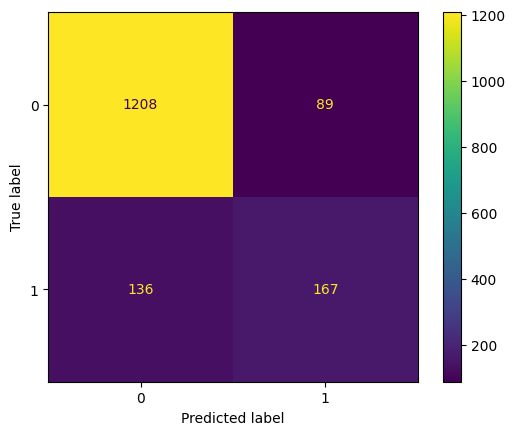

In [49]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
mod_pred_t = model.predict(features_valid)
cm = confusion_matrix(target_valid, mod_pred_t)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()

There is an error rate of roughly 16% as seen from this matrix, roughly 1 in 6 predictions are likely to be false.

## Final model training on the training and validation set combined

We will now train the final random forest model on the larger data set that contains training and validation sets and test the predictions on test.

In [53]:
features_trainf = pd.concat([features_train, features_valid])
target_trainf = pd.concat([target_train, target_valid])
#upsampling
features_main_zeros = features_trainf[target_trainf == 0]
features_main_ones = features_trainf[target_trainf == 1]
target_main_zeros = target_trainf[target_trainf == 0]
target_main_ones = target_trainf[target_trainf == 1]
features_m_upsampled = pd.concat([features_main_zeros] + [features_main_ones] * 3)
target_m_upsampled = pd.concat([target_main_zeros] + [target_main_ones] * 3)
features_m_upsampled, target_m_upsampled = shuffle(features_m_upsampled, target_m_upsampled, random_state=12345)
#model training
#train final model on main set
model_f = RandomForestClassifier(random_state=12345, n_estimators=258, max_depth=19)
model_f.fit(features_m_upsampled,target_m_upsampled)
prediction_f = model_f.predict(features_test)
accuracy_f = accuracy_score(target_test, prediction_f)
f1score_f = f1_score(target_test,prediction_f)
print(f"Accuracy of selected model: {accuracy_f} F1 score of selected model: {f1score_f}")

Accuracy of selected model: 0.852 F1 score of selected model: 0.6084656084656085


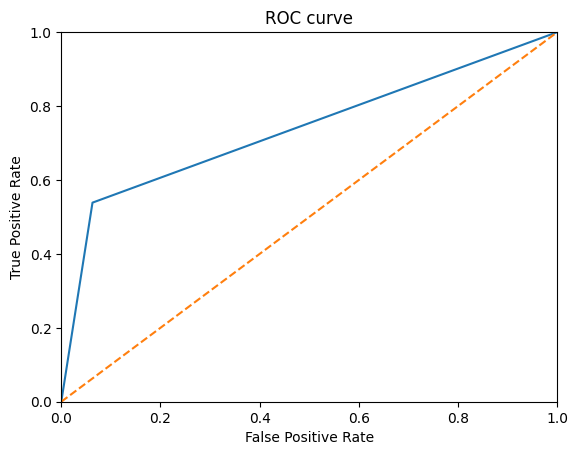

AUC-ROC metric for this model is:0.7378523116228035


In [54]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
# plot the curve
fpr, tpr, thresholds = roc_curve(target_test, prediction_f)
plt.figure()
plt.plot(fpr,tpr)
# ROC curve for random model (looks like a straight line)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()
auc_roc = roc_auc_score(target_test, prediction_f)
print(f"AUC-ROC metric for this model is:{auc_roc}")

The area under the ROC curve is 0.7378 which is higher than the random model value of 0.5. The curve is not a smoothened curve but rather angled. There is a steep increase in True positives at lower values of false positives after which the false positive and true positive rates both gradually increase and approach one. This would likely mean that any further improvements in recall will lead to a loss in precision in this model. this largely agrees with the F1-score. The highest achievable F1 score has consistently hovered around 0.6 with further improvements in class recognition being hard to achieve.

# Conclusion

In this project we have tried to identify the churn in customers for Beta Bank (the client). We looked ata a dataset that included data for 10000 customers. There were both categorical and continuous features in the dataset.
After cleaning up the dataset, imputing the missing values in the tenure category using the iterative imputer, performing some preliminary analysis and removing uneccessary features, we set upon training the model.

We noticed that there is a significant class imbalance with customers who have churned representing a very small fraction of the overall data. We also noticed that there were differences in the user profiles when grouped by georgaphical region or gender. This could be useful later when the model is sanity checked.

We trained three different models, decision tree, random forest and logistic regression without taking the class imbalance into account and then later taking it into account by tuning the hyper parameter class weights.
We then tried up and down sampling on the best identified model, the random forest. Upsampling gave us a better F1 score and accuracy and we decided to use this in future training.

A random search and grid search with cv=5 and different ranges of number of trees and maximum depth was used to find the best hyper parameter results. The results were not significantly different. We finalized 258 trees at a max depth of 20 for our final model.

Some basic sanity check measures were performed. The model did not perform significantly better than baseline when it came to accuracy and the importances rankings were biased towards continuous features. Permutation importance gave a less biased ranking that largely made sense based on our previous analysis of the data.
With the confusion matrix we determined that the predictions were likely false 1 in 6 times or 16% of the predictions made by the model are likely false.

Since the model met the F1 score criteria established earlier (>0.59) and had better than baseline accuracy and the features ranking largely agreed with our understanding of the data, we trained the final model with random forest classifier on the training and validation set combined and predicted the class for the test set. Accuracy and F1 scores were largely consistent with earlier values and the F1 score stayed above the required threshold of 0.59.

When the ROC curve was plotted and the area under the curve calculated it was above the random model curve area at 0.7378. The curve was higher than the random model curve and this seemed to further indicate the model trained was a reasonable predictor of customer churn.

If Beta Bank wishes to assume a less stringent criteria to ensure that all clients likely to leave are indentified, it is possible to tune the threshold further. However, a lot of false positives are likely in this scenario.